# Word Embedding - Home Assigment
## Dr. Omri Allouche 2018. YData Deep Learning Course

[Open in Google Colab](https://colab.research.google.com/github/omriallouche/deep_learning_course/blob/master/DL_word_embedding_assignment.ipynb)
    
    
In this exercise, you'll use word vectors trained on a corpus of 380,000 lyrics of songs from MetroLyrics (https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics).  
The dataset contains these fields for each song, in CSV format:
1. index
1. song
1. year
1. artist
1. genre
1. lyrics

Before doing this exercise, we recommend that you go over the "Bag of words meets bag of popcorn" tutorial (https://www.kaggle.com/c/word2vec-nlp-tutorial)

Other recommended resources:
- https://rare-technologies.com/word2vec-tutorial/
- https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [67]:
import re
import os
import pickle
import spacy
import logging
import multiprocessing

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
from pathlib import Path
from collections import defaultdict, Counter
from spacy_langdetect import LanguageDetector
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser

In [4]:
sns.set_style("darkgrid")
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)


In [5]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)
text_in_brackets = re.compile("\[(.*?)\]")
non_alpha = re.compile("[^A-Za-z']+")
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt='%H:%M:%S', level=logging.INFO)


In [6]:
model_id = "model_5"

if not os.path.exists(f'data/{model_id}'):
    os.mkdir(f'data/{model_id}')
clean_corpus_file = f'data/{model_id}/clean_texts.pkl'
model_file = f'data/{model_id}/word2vec.model'
bigrams_file = f'data/{model_id}/bigrams'
trigrams_file = f'data/{model_id}/trigrams'
vocabulary_file = f'data/{model_id}/vocabulary'
predicted_sentiment_file = f"data/{model_id}/predicted_sentiment.txt"
genre_counts_file = f"data/{model_id}/genre_counts.txt"
relative_abundance_file = f"data/{model_id}/relative_abundance.csv"
X_w2v_vectors_file = f"data/{model_id}/X_w2v_vectors.txt"
X_w2v_vectors_pickled_file = f"data/{model_id}/X_w2v_vectors.np"
X_w2v_indexes_for_nn = f"data/{model_id}/X_w2v_indexes"

In [7]:
# Load sentiment dataset
df = pd.read_csv("data/380000-lyrics-from-metrolyrics.zip", header=0)
sentiment = pd.read_csv('data/SemEval2015-English-Twitter-Lexicon.txt', delimiter='\t', header=0,
                        names=['sentiment', 'term'])
sentiment.term = sentiment.term.str.replace('#', '')
sentiment.set_index('term', inplace=True)

sentiment_terms = ['_'.join(i.split(' ')).replace("'", "_'_") for i in sentiment.index if ' ' in i]

### Train word vectors
Train word vectors using the Skipgram Word2vec algorithm and the gensim package.
Make sure you perform the following:
- Tokenize words
- Lowercase all words
- Remove punctuation marks
- Remove rare words
- Remove stopwords

Use 300 as the dimension of the word vectors. Try different context sizes.

In [58]:
def prepare_clean_data(songs_df: pd.DataFrame) -> pd.DataFrame:
    if not Path(clean_corpus_file).exists():
        def cleaning(i, doc):
            if i % 10000 == 0:
                print(f"cleaning data: song {i} / {df.shape[0]} - {round(i / df.shape[0], 2) * 100}%")
            if not doc._.language["language"] == "en":
                return
            _txt = [token.text for token in doc if not token.is_stop]  # tokenize, remove stopwords, lowercase
            if len(_txt) > 2:
                return ' '.join(_txt)

        # Remove any non-alpha words and text in square brackets
        brief_cleaning = (non_alpha.sub(' ', text_in_brackets.sub(' ', str(row))).lower() for row in songs_df.lyrics)
        t = time()
        texts = [cleaning(i, doc) for i, doc in enumerate(nlp.pipe(brief_cleaning, batch_size=6000, n_threads=16))]
        pickle.dump(texts, open(clean_corpus_file, 'wb'))
        print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

    texts = pickle.load(open(clean_corpus_file, 'rb'))
    df_clean = pd.DataFrame({'clean': texts})
    songs_df['clean_lyrics'] = df_clean
    songs_df['genre'] = songs_df.genre.astype('category')
    return songs_df

In [9]:
def train_w2v_model() -> (Phraser, Word2Vec):
    # Build Word2Vec model
    if not Path(model_file).exists():
        sent = [row.split() for row in df['clean_lyrics'] if row]
        # Build collocations
        if not Path(bigrams_file).exists():
            bigram_phrases = Phrases(sent, min_count=30, progress_per=10000, max_vocab_size=200000,
                                     common_terms=sentiment_terms)
            bigram = Phraser(bigram_phrases)
            bigram.save(bigrams_file)
            trigram_phrases = Phrases(bigram[sent], min_count=30, progress_per=10000, max_vocab_size=200000,
                                      common_terms=sentiment_terms)
            trigram = Phraser(trigram_phrases)
            trigram.save(trigrams_file)

        trigram = Phrases.load(trigrams_file)

        sentences = trigram[sent]

        cores = multiprocessing.cpu_count()
        w2v_model = Word2Vec(min_count=20,  # Remove rare words
                             window=2,
                             size=300,
                             sample=6e-5,
                             alpha=0.03,
                             min_alpha=0.0007,
                             negative=20,
                             workers=cores - 1)

        t = time()

        w2v_model.build_vocab(sentences, progress_per=10000)

        print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))
        w2v_model.vocabulary.save(vocabulary_file)

        t = time()

        w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

        print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

        w2v_model.save(model_file)
    trigram = Phrases.load(trigrams_file)
    w2v_model = Word2Vec.load(model_file)

    return trigram, w2v_model

In [10]:
def prepare_sentiment_for_known_words():
    results = []
    for v in sentiment.index.values:
        if v in w2v_model.wv:  # found in w2v by exact match
            results.append(np.array(w2v_model.wv[v]))
        elif '_'.join([i.lemma_ for i in nlp(v)]) in w2v_model.wv:  # found in w2v by lemma
            results.append(np.array(w2v_model.wv['_'.join([i.lemma_ for i in nlp(v)])]))
        else:  # not found in w2v
            results.append(None)
    print(len(results))
    print(np.array(results).shape)
    t = np.concatenate((sentiment.reset_index(), np.array(results).reshape(1514, -1)), axis=1)
    p = pd.DataFrame(t)
    p = p[~p[2].isnull()]
    return p

In [11]:
def prepare_relative_abundance(songs_df):
    """
    # Keep only the 3,000 most frequent words (after removing stopwords)
    # For this list, compute for each word its relative abundance in each of the genres
    # Compute the ratio between the proportion of each word in each genre and the proportion of the word
    # in the entire corpus (the background distribution)
    # Pick the top 50 words for each genre. These words give good indication for that genre.
    :param songs_df:
    :return:
    """
    if not Path(genre_counts_file).exists():
        counts = defaultdict(Counter)

        for i, (k, v) in enumerate(songs_df.iterrows()):
            if v.clean_lyrics:
                counts[v.genre] += Counter([t for t in v.clean_lyrics.split() if len(t) > 2])

        pickle.dump(counts, open(genre_counts_file, "wb"))
    else:
        counts = pickle.load(open(genre_counts_file, "br"))
    if not Path(relative_abundance_file).exists():
        total_count = Counter()
        for k in counts.keys():
            total_count += counts[k]

        total_elements = sum(total_count.values())

        top_3k = total_count.most_common(3000)

        results = []
        for w in top_3k:
            res = {"term": w[0], "proportion_in_corpus": w[1] / total_elements, }
            for k in counts.keys():
                res[k] = (counts[k][w[0]] / sum(counts[k].values())) / w[1] / total_elements
            results.append(res)

        relative_abundance_df = pd.DataFrame.from_records(results).set_index('term')
        relative_abundance_df.to_csv(relative_abundance_file)
    relative_abundance_df = pd.read_csv(relative_abundance_file).set_index('term')

    return relative_abundance_df


In [12]:
def plot_tsne(relative_abundance_df):
    """
    # Join the words from all genres into a single list of top significant words.
    # Compute tSNE transformation to 2D for all words, based on their word vectors
    # Plot the list of the top significant words in 2D. Next to each word output its text.
    # The color of each point should indicate the genre for which it is most significant.

    :param relative_abundance_df:
    :return:
    """
    colors_map = zip(
        ['Pop', 'Hip-Hop', 'Rock', 'Metal', 'Country', 'Jazz', 'Electronic', 'Folk', 'R&B', 'Indie'],
        ['yellow', 'red', 'blue', 'orange', 'purple', 'green', 'brown', 'black', 'grey', 'pink']
    )
    arrays = np.empty((0, 300), dtype='f')
    word_labels = []
    color_list = []
    for genre, color in colors_map:
        for word in relative_abundance_df[genre].sort_values(ascending=False)[:50].index:
            arrays = np.append(arrays, w2v_model.wv[word].reshape(1, 300), axis=0)
            word_labels.append(word)
            color_list.append(color)
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=50).fit_transform(arrays)
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    # Sets everything up to plot
    tnse_df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                            'y': [y for y in Y[:, 1]],
                            'words': word_labels,
                            'color': color_list})
    fig, _ = plt.subplots()
    fig.set_size_inches(15, 15)
    # Basic plot
    p1 = sns.regplot(data=tnse_df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': tnse_df['color']
                                  }
                     )
    # Adds annotations one by one with a loop
    for line in range(0, tnse_df.shape[0]):
        p1.text(tnse_df["x"][line],
                tnse_df['y'][line],
                '  ' + tnse_df["words"][line].title(),
                horizontalalignment='left',
                verticalalignment='bottom', size='medium',
                color=tnse_df['color'][line],
                weight='normal'
                ).set_size(15)
    plt.xlim(Y[:, 0].min() - 50, Y[:, 0].max() + 50)
    plt.ylim(Y[:, 1].min() - 50, Y[:, 1].max() + 50)
    plt.title('t-SNE visualization for top 50 terms for each genre')
    plt.show()


In [36]:
def train_sentiment_model():
    known_words_sentiment = prepare_sentiment_for_known_words()
    X = known_words_sentiment[2].values.tolist()
    y = list(known_words_sentiment[1].values)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression(normalize=True)
    model.fit(X_train, y_train)
    np.stack((model.predict(X_test), y_test), axis=1)
    print("train MSE:", np.mean((y_train - model.predict(X_train)) ** 2))
    print("test MSE:", np.mean((y_test - model.predict(X_test)) ** 2))
    return model


In [14]:
def predict_sentiment_for_new_tesrms(sentiment_model):
    # predict sentiment for all the words in the w2v vocabulary
    if not Path(predicted_sentiment_file).exists():
        with open(predicted_sentiment_file, "wt") as f:
            for i, k in enumerate(w2v_model.wv.vocab):
                print(f"{k}:{sentiment_model.predict([w2v_model.wv[k]])[0]}", file=f)

In [64]:
songs_df.genre.cat.categories

Index(['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz', 'Metal', 'Not Available', 'Other', 'Pop', 'R&B', 'Rock'], dtype='object')

In [70]:
def nb_classification_on_bow(songs_df):
    sklearn_pipeline = Pipeline([
        ('vect', CountVectorizer(max_features=10000)),
        ('clf', MultinomialNB()),
    ])
    y = list(songs_df[~df.genre.isin(['Not Available', 'Other'])].drop_duplicates().dropna().genre.values)
    X = list(songs_df[~df.genre.isin(['Not Available', 'Other'])].drop_duplicates().dropna().clean_lyrics.values)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    sklearn_pipeline.fit(X_train, y_train)
    print("sklearn multinomial NB accuracy =", sum(sklearn_pipeline.predict(X_test) == y_test) / len(y_test))
    y_pred = sklearn_pipeline.predict(X_test)
    cnf_matrix = confusion_matrix(y_test, y_pred, songs_df.genre.cat.categories)
    print(classification_report(y_test, y_pred, digits=3))
    plt.figure(figsize=(12, 8))
    sns.heatmap(cnf_matrix, annot=True, fmt="d",)
    plt.show()

In [16]:
def classification_on_word_vectors(phraser, w2v_model, X, y):
    if not Path(X_w2v_vectors_file).exists():
        t = time()
        with open(X_w2v_vectors_file, 'a') as f_handle:
            for song in X:
                song_arrays = np.empty((0, 300), dtype='f')
                for word in phraser[song.split()]:
                    if word in w2v_model.wv:
                        song_arrays = np.append(song_arrays, w2v_model.wv[word].reshape(1, 300), axis=0)

                np.savetxt(f_handle, song_arrays.mean(axis=0))
        print('Time to prepare mean vectors: {} mins'.format(round((time() - t) / 60, 2)))
        X_vectors = np.loadtxt(X_w2v_vectors_file)
        print(X_vectors.shape)
        X_vectors.dump(X_w2v_vectors_pickled_file)
    X_vectors = np.load(X_w2v_vectors_pickled_file, allow_pickle=True).reshape(-1, 300)
    X_vec = X_vectors[~np.any(np.isnan(X_vectors), axis=1)]
    y_vec = np.array(y)[~np.any(np.isnan(X_vectors), axis=1)]
    X_train_vec, X_test_vec, y_train_vec, y_test_vec = train_test_split(X_vec, y_vec, test_size=0.2, random_state=42)
    clf = ExtraTreesClassifier()
    clf.fit(X_train_vec, y_train_vec)
    print("sklearn ExtraTreesClassifier on W2V vectors accuracy =",
          sum(clf.predict(X_test_vec) == y_test_vec) / len(y_test_vec))

In [17]:
def classification_with_tfidf_weighting(phraser, w2v_model, X, y):
    """
    Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    tfidf = TfidfVectorizer(analyzer=lambda x: x)
    tfidf.fit([ii.split() for ii in X_train])
    max_idf = max(tfidf.idf_)
    word2weight = defaultdict(
        lambda: max_idf,
        [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    train_transformed = np.array([
        np.mean([w2v_model.wv[w] * word2weight[w]
                 for w in words if w in w2v_model.wv] or
                [np.zeros(300)], axis=0)
        for words in [phraser[ii.split()] for ii in X_train]
    ])
    test_transformed = np.array([
        np.mean([w2v_model.wv[w] * word2weight[w]
                 for w in words if w in w2v_model.wv] or
                [np.zeros(300)], axis=0)
        for words in [phraser[ii.split()] for ii in X_test]
    ])
    clf = ExtraTreesClassifier()
    clf.fit(train_transformed, y_train)
    print("sklearn ExtraTreesClassifier on weighted W2V vectors accuracy =",
          sum(clf.predict(test_transformed) == y_test) / len(y_test))

In [59]:
songs_df = prepare_clean_data(df)
phraser, w2v_model = train_w2v_model()

INFO - 19:36:10: loading Phrases object from data/model_5/trigrams
INFO - 19:36:10: loaded data/model_5/trigrams
INFO - 19:36:10: older version of Phrases loaded without corpus_word_count
INFO - 19:36:10: Setting it to 0, do not use it in your scoring function.
INFO - 19:36:10: loading Word2Vec object from data/model_5/word2vec.model
INFO - 19:36:11: loading wv recursively from data/model_5/word2vec.model.wv.* with mmap=None
INFO - 19:36:11: setting ignored attribute vectors_norm to None
INFO - 19:36:11: loading vocabulary recursively from data/model_5/word2vec.model.vocabulary.* with mmap=None
INFO - 19:36:11: loading trainables recursively from data/model_5/word2vec.model.trainables.* with mmap=None
INFO - 19:36:11: setting ignored attribute cum_table to None
INFO - 19:36:11: loaded data/model_5/word2vec.model


### Review most similar words
Get initial evaluation of the word vectors by analyzing the most similar words for a few interesting words in the text. 

Choose words yourself, and find the most similar words to them.

In [32]:
# Word2Vec sanity check
print("demon:")
print(w2v_model.wv.most_similar(positive=["demon"]))
print("heaven:")
print(w2v_model.wv.most_similar(positive=["heaven"]))
print("bourbon:")
print(w2v_model.wv.most_similar(positive=["bourbon"]))

demon:
[('demons', 0.5105950832366943), ('devil', 0.47809353470802307), ('evil', 0.44540926814079285), ('beast', 0.37569060921669006), ('satan', 0.37276947498321533), ('unholy', 0.3713604211807251), ('exorcised', 0.3711298704147339), ('infernal', 0.3684452176094055), ('possessed', 0.3577425181865692), ('soul', 0.353899210691452)]
heaven:
[('angel', 0.6051561832427979), ('heavens', 0.563835620880127), ('angels', 0.5333641767501831), ('lord', 0.5298174619674683), ('paradise', 0.5186969041824341), ('earth', 0.5062729716300964), ('hell', 0.49611344933509827), ('god', 0.4909436106681824), ('knows', 0.47132739424705505), ('forever', 0.47126954793930054)]
bourbon:
[('scotch', 0.3873857259750366), ('whiskey', 0.38529908657073975), ('gin', 0.3613254427909851), ('drank', 0.32504308223724365), ('swig', 0.3216247856616974), ('drink', 0.31700679659843445), ('drinking', 0.3168026804924011), ('beer', 0.3022931218147278), ('bathtub', 0.3004748821258545), ('remi', 0.2988422214984894)]


### Word Vectors Algebra
We've seen in class examples of algebraic games on the word vectors (e.g. man - woman + king = queen ). 

Try a few vector algebra terms, and evaluate how well they work. Try to use the Cosine distance and compare it to the Euclidean distance.

In [33]:
# TODO: distance compare
print('"boy" - "man"')
print(w2v_model.wv.most_similar(positive=["boy"], negative=["man"]))
print('"doctor" - "man"')
print(w2v_model.wv.most_similar(positive=["doctor"], negative=["man"]))
print('"doctor" - "woman"')
print(w2v_model.wv.most_similar(positive=["doctor"], negative=["woman"]))
print('"love" + "vodka"')
print(w2v_model.wv.most_similar(positive=["love", "vodka"]))
print('find not related ["best", "good", "better", "god"]')
print(w2v_model.wv.doesnt_match(["best", "good", "better", "god"]))

"boy" - "man"
[('baby', 0.3428463637828827), ('girl', 0.3301248848438263), ('urin', 0.32586199045181274), ('ayeee', 0.31955674290657043), ('yoona', 0.31282320618629456), ('coy', 0.3111511766910553), ('bame', 0.29333412647247314), ('wonhae', 0.29281312227249146), ('boys', 0.29150402545928955), ('motherfuckerin', 0.28882837295532227)]
"doctor" - "man"
[('palpitations', 0.33868399262428284), ('curing', 0.3335195481777191), ('physician', 0.32860082387924194), ('embalmed', 0.3201397955417633), ('plop', 0.31696003675460815), ('diagnose', 0.3134455680847168), ('caustic', 0.3083668649196625), ('hospital', 0.30727431178092957), ('uette', 0.3072437047958374), ('meds', 0.306954950094223)]
"doctor" - "woman"
[('doc', 0.36692124605178833), ('diagnosed', 0.3404824435710907), ('physician', 0.33129727840423584), ('psychiatrist', 0.3181054890155792), ('meds', 0.3158576488494873), ('resuscitate', 0.3118826150894165), ('popped', 0.30900490283966064), ('diagnose', 0.3065749406814575), ('phil', 0.306056261

/home/alexs/.virtualenvs/ydata/local/lib/python3.7/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


## Sentiment Analysis
Estimate sentiment of words using word vectors.  
In this section, we'll use the SemEval-2015 English Twitter Sentiment Lexicon.  
The lexicon was used as an official test set in the SemEval-2015 shared Task #10: Subtask E, and contains a polarity score for words in range -1 (negative) to 1 (positive) - http://saifmohammad.com/WebPages/SCL.html#OPP

Build a classifier for the sentiment of a word given its word vector. Split the data to a train and test sets, and report the model performance on both sets.

In [37]:
# Prepare sentiment for words found in sentiment dataset and w2v model
sentiment_model = train_sentiment_model()

1514
(1514,)
train MSE: 0.057774258563343235
test MSE: 0.18264703562202728


Use your trained model from the previous question to predict the sentiment score of words in the lyrics corpus that are not part of the original sentiment dataset. Review the words with the highest positive and negative sentiment. Do the results make sense?

In [38]:
predict_sentiment_for_new_tesrms(sentiment_model)

In [41]:
for i, k in enumerate(w2v_model.wv.vocab):
    if i > 50:
        break
    print(f"{k}:{sentiment_model.predict([w2v_model.wv[k]])[0]}")

oh:0.1918407827615738
baby:0.3956679701805115
know:0.17011593282222748
gon:0.03504796326160431
na:-0.036725327372550964
cut:-0.13916775584220886
right:0.2552297115325928
chase:0.507696807384491
women:0.30491769313812256
like:0.2718852758407593
think:0.03973062336444855
created:0.3326476812362671
special:1.4893362522125244
purpose:0.20761637389659882
feel:0.22297419607639313
let:0.26932424306869507
lost:-0.43271076679229736
need:0.2991376519203186
work:0.29054582118988037
'cause:0.16590659320354462
boss:-0.6293191313743591
real:0.17052046954631805
want:0.15344275534152985
consider:-0.07976777851581573
lucky:0.9176334142684937
big:-0.09731176495552063
deal:-0.17386944591999054
got:0.451147198677063
key:0.7042615413665771
heart:0.3295654058456421
ai:0.19883273541927338
open:-0.05619015544652939
body:0.5360643863677979
secrets:0.4971398115158081
inside:0.06802074611186981
lie:-0.5536649227142334
wide:-0.10077397525310516
strong:0.24953751266002655
wo:-0.29714131355285645
fit:-0.03839290887

### Visualize Word Vectors
In this section, you'll plot words on a 2D grid based on their inner similarity. We'll use the tSNE transformation to reduce dimensions from 300 to 2. You can get sample code from https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial or other tutorials online.

Perform the following:
- Keep only the 3,000 most frequent words (after removing stopwords)
- For this list, compute for each word its relative abundance in each of the genres
- Compute the ratio between the proportion of each word in each genre and the proportion of the word in the entire corpus (the background distribution)
- Pick the top 50 words for each genre. These words give good indication for that genre. Join the words from all genres into a single list of top significant words. 
- Compute tSNE transformation to 2D for all words, based on their word vectors
- Plot the list of the top significant words in 2D. Next to each word output its text. The color of each point should indicate the genre for which it is most significant.

You might prefer to use a different number of points or a slightly different methodology for improved results.  
Analyze the results.

In [42]:
relative_abundance_df = prepare_relative_abundance(songs_df)

In [43]:
print(relative_abundance_df['Country'].sort_values(ascending=False)[:10])

term
tennessee     1.920637e-14
cowboy        1.544405e-14
lonesome      1.413750e-14
teardrops     1.170974e-14
texas         1.104883e-14
sweetheart    1.049874e-14
whiskey       1.042195e-14
ole           1.038817e-14
cotton        1.034391e-14
county        1.028841e-14
Name: Country, dtype: float64


In [44]:
print(relative_abundance_df['Metal'].sort_values(ascending=False)[:10])

term
corpse       1.504386e-14
existence    1.412923e-14
eternal      1.411205e-14
wrath        1.411046e-14
mortal       1.362297e-14
decay        1.351850e-14
agony        1.339233e-14
chaos        1.327873e-14
mankind      1.310147e-14
humanity     1.300222e-14
Name: Metal, dtype: float64


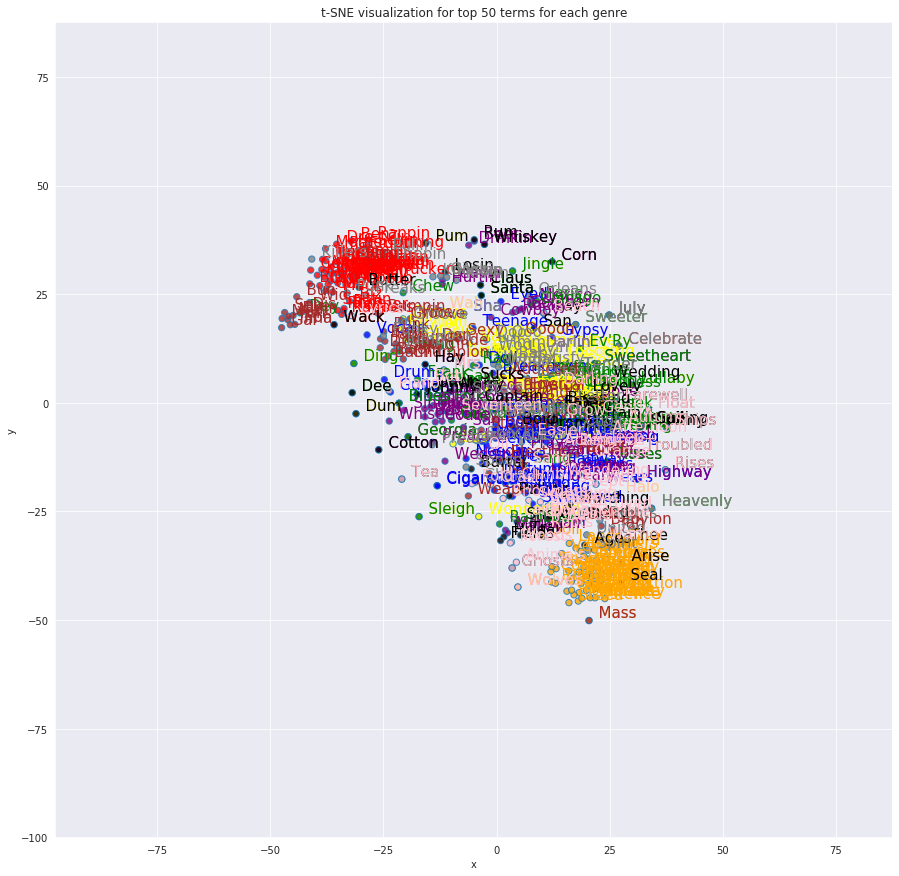

In [46]:
plot_tsne(relative_abundance_df)
# (
#     ['Pop', 'Hip-Hop', 'Rock', 'Metal', 'Country', 'Jazz', 'Electronic', 'Folk', 'R&B', 'Indie'],
#     ['yellow', 'red', 'blue', 'orange', 'purple', 'green', 'brown', 'black', 'grey', 'pink']
# )

## Text Classification
In this section, you'll build a text classifier, determining the genre of a song based on its lyrics.

### Text classification using Bag-of-Words
Build a Naive Bayes classifier based on the bag of Words.  
You will need to divide your dataset into a train and test sets.

sklearn multinomial NB accuracy = 0.4679576161391819
              precision    recall  f1-score   support

     Country      0.320     0.488     0.386      2781
  Electronic      0.193     0.157     0.173      1417
        Folk      0.088     0.275     0.134       385
     Hip-Hop      0.702     0.759     0.729      4588
       Indie      0.076     0.185     0.108       605
        Jazz      0.264     0.412     0.321      1478
       Metal      0.454     0.757     0.568      4360
         Pop      0.377     0.375     0.376      6997
         R&B      0.094     0.211     0.130       672
        Rock      0.681     0.415     0.515     19941

    accuracy                          0.468     43224
   macro avg      0.325     0.403     0.344     43224
weighted avg      0.535     0.468     0.480     43224



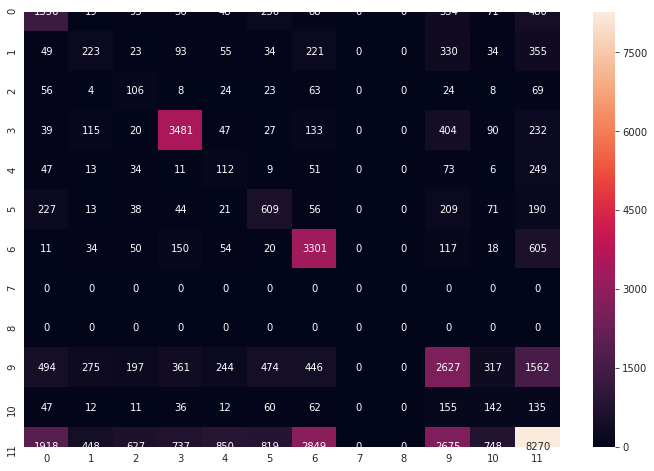

In [71]:
nb_classification_on_bow(songs_df)

Show the confusion matrix.

Show the classification report - precision, recall, f1 for each class.

### Text classification using Word Vectors
#### Average word vectors
Do the same, using a classifier that averages the word vectors of words in the document.

In [73]:
X = songs_df.clean_lyrics.values[~songs_df.genre.isin(['Not Available', 'Other']) & ~songs_df.clean_lyrics.isnull()]
y = songs_df.genre.values[~songs_df.genre.isin(['Not Available', 'Other']) & ~songs_df.clean_lyrics.isnull()]

classification_on_word_vectors(phraser, w2v_model, X, y)

sklearn ExtraTreesClassifier on W2V vectors accuracy = 0.6256477882657783


#### TfIdf Weighting
Do the same, using a classifier that averages the word vectors of words in the document, weighting each word by its TfIdf.


In [74]:
classification_with_tfidf_weighting(phraser, w2v_model, X, y)

sklearn ExtraTreesClassifier on weighted W2V vectors accuracy = 0.62525448824727


### Text classification using ConvNet
Do the same, using a ConvNet.  
The ConvNet should get as input a 2D matrix where each column is an embedding vector of a single word, 
and words are in order. Use zero padding so that all matrices have a similar length.  
Some songs might be very long. Trim them so you keep a maximum of 128 words (after cleaning stop words 
and rare words).  
Initialize the embedding layer using the word vectors that you've trained before, but allow them to 
change during training.  

Extra: Try training the ConvNet with 2 slight modifications:
1. freezing the the weights trained using Word2vec (preventing it from updating)
1. random initialization of the embedding layer

You are encouraged to try this question on your own.  

You might prefer to get ideas from the paper "Convolutional Neural Networks for Sentence Classification" (Kim 2014, [link](https://arxiv.org/abs/1408.5882)).

There are several implementations of the paper code in PyTorch online (see for example [this repo](https://github.com/prakashpandey9/Text-Classification-Pytorch) for a PyTorch implementation of CNN and other architectures for text classification). If you get stuck, they might provide you with a reference for your own code.

In [78]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print(f"CUDA is available! Training on {torch.cuda.get_device_name(0)}...")
    device = torch.device("cuda:0")
else:
    print("CUDA is not available. Training on CPU...")
    device = 'cpu'


CUDA is not available. Training on CPU...


In [79]:
class CNN(nn.Module):
    def __init__(self, batch_size, output_size, in_channels, out_channels, kernel_heights, stride, padding, keep_probab,
                 vocab_size, embedding_length, weights, train_w2v_weights):
        super(CNN, self).__init__()

        """
        Arguments
        ---------
        batch_size : Size of each batch which is same as the batch_size of the data returned by the TorchText BucketIterator
        output_size : 2 = (pos, neg)
        in_channels : Number of input channels. Here it is 1 as the input data has dimension = (batch_size, num_seq, embedding_length)
        out_channels : Number of output channels after convolution operation performed on the input matrix
        kernel_heights : A list consisting of 3 different kernel_heights. Convolution will be performed 3 times and finally results from each kernel_height will be concatenated.
        keep_probab : Probability of retaining an activation node during dropout operation
        vocab_size : Size of the vocabulary containing unique words
        embedding_length : Embedding dimension of GloVe word embeddings
        weights : Pre-trained word_embeddings which we will use to create our word_embedding look-up table
        train_w2v_weights bool: include word embeddings in the network training
        --------

        """
        self.batch_size = batch_size
        self.output_size = output_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_heights = kernel_heights
        self.stride = stride
        self.padding = padding
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
        self.word_embeddings.weight = nn.Parameter(torch.Tensor(weights), requires_grad=train_w2v_weights)
        self.conv1 = nn.Conv2d(in_channels, out_channels, (kernel_heights[0], embedding_length), stride, padding)
        self.conv2 = nn.Conv2d(in_channels, out_channels, (kernel_heights[1], embedding_length), stride, padding)
        self.conv3 = nn.Conv2d(in_channels, out_channels, (kernel_heights[2], embedding_length), stride, padding)
        self.dropout = nn.Dropout(keep_probab)
        self.label = nn.Linear(len(kernel_heights) * out_channels, output_size)

    def conv_block(self, input, conv_layer):
        conv_out = conv_layer(input)  # conv_out.size() = (batch_size, out_channels, dim, 1)
        activation = F.relu(conv_out.squeeze(3))  # activation.size() = (batch_size, out_channels, dim1)
        max_out = F.max_pool1d(activation, activation.size()[2]).squeeze(
            2)  # maxpool_out.size() = (batch_size, out_channels)

        return max_out

    def forward(self, input_sentences, batch_size=None):
        """
        The idea of the Convolutional Neural Netwok for Text Classification is very simple. We perform convolution operation on the embedding matrix
        whose shape for each batch is (num_seq, embedding_length) with kernel of varying height but constant width which is same as the embedding_length.
        We will be using ReLU activation after the convolution operation and then for each kernel height, we will use max_pool operation on each tensor
        and will filter all the maximum activation for every channel and then we will concatenate the resulting tensors. This output is then fully connected
        to the output layers consisting two units which basically gives us the logits for both positive and negative classes.

        Parameters
        ----------
        input_sentences: input_sentences of shape = (batch_size, num_sequences)
        batch_size : default = None. Used only for prediction on a single sentence after training (batch_size = 1)

        Returns
        -------
        Output of the linear layer containing logits for pos & neg class.
        logits.size() = (batch_size, output_size)

        """

        input = self.word_embeddings(torch.LongTensor(input_sentences))
        # input.size() = (batch_size, num_seq, embedding_length)
        input = input.reshape(-1, 1, self.out_channels, self.embedding_length)
        # input.size() = (batch_size, 1, num_seq, embedding_length)
        max_out1 = self.conv_block(input, self.conv1)
        max_out2 = self.conv_block(input, self.conv2)
        max_out3 = self.conv_block(input, self.conv3)

        all_out = torch.cat((max_out1, max_out2, max_out3), 1)
        # all_out.size() = (batch_size, num_kernels*out_channels)
        fc_in = self.dropout(all_out)
        # fc_in.size()) = (batch_size, num_kernels*out_channels)
        logits = self.label(fc_in)

        return logits

In [80]:
def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)


def train_model(model, X_train, y_train, epoch):
    total_epoch_loss = 0
    total_epoch_acc = 0
    if train_on_gpu:
        model.to(device)
    optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()))
    steps = 0
    model.train()

    batches = range(0, len(X_train), batch_size)
    for idx in batches:
        texts = X_train[idx: idx + batch_size]
        target = y_train[idx: idx + batch_size]
        target = torch.autograd.Variable(torch.LongTensor(target))
        if train_on_gpu:
            texts = torch.FloatTensor(texts).to(device)
            target = target.to(device)

        optim.zero_grad()
        prediction = model(texts)
        loss = loss_fn(prediction, target)
        num_corrects = (prediction.argmax(axis=1).data == target.data).sum()
        acc = 100.0 * num_corrects / len(texts)
        loss.backward()
        clip_gradient(model, 1e-1)
        optim.step()
        steps += 1

        if steps % 100 == 0:
            print(
                f'Epoch: {epoch + 1}, Idx: {idx + 1}, Training Loss: {loss.item():.4f}, Training Accuracy: {acc.item(): .2f}%')

        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()

    return total_epoch_loss / len(batches), total_epoch_acc / len(batches)


def eval_model(model, X_test, y_test):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.eval()
    with torch.no_grad():
        batches = range(0, len(X_test), batch_size)
        for idx in batches:
            texts = X_test[idx: idx + batch_size]
            target = y_test[idx: idx + batch_size]
            target = torch.autograd.Variable(torch.LongTensor(target))
            if train_on_gpu:
                texts = torch.FloatTensor(texts).to(device)
                target = target.to(device)

            prediction = model(texts)
            loss = loss_fn(prediction, target)
            num_corrects = (prediction.argmax(axis=1).data == target.data).sum()
            acc = 100.0 * num_corrects / len(texts)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss / len(batches), total_epoch_acc / len(batches)

In [83]:
learning_rate = 2e-5
batch_size = 32
output_size = 11
embedding_length = 300

embedding_matrix = np.zeros((len(w2v_model.wv.vocab), 300))
for i in range(len(w2v_model.wv.vocab)):
    embedding_vector = w2v_model.wv[w2v_model.wv.index2word[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

        
# with train_w2v_weights we are checking trainable and non-trainable w2v weights layer
model = CNN(batch_size=batch_size, output_size=output_size, in_channels=1, out_channels=128, 
            kernel_heights=(3, 4, 5), stride=1, padding=0, keep_probab=0.2, vocab_size=200000, 
            embedding_length=embedding_length, weights=embedding_matrix, train_w2v_weights=True)

loss_fn = F.cross_entropy

y = list(songs_df[~df.genre.isin(['Not Available', 'Other'])].drop_duplicates().dropna().genre.values)
X = list(songs_df[~df.genre.isin(['Not Available', 'Other'])].drop_duplicates().dropna().clean_lyrics.values)

if not Path(X_w2v_indexes_for_nn).exists():
    X_ind = []
    for song in X:
        l = [w2v_model.wv.vocab[i].index if i in w2v_model.wv else 0 for i in phraser[song.split()]][:128]
        l = l + [0] * (128 - len(l))
        X_ind.append(l)
    pickle.dump(X_ind, open(X_w2v_indexes_for_nn, "wb"))
X_ind = pickle.load(open(X_w2v_indexes_for_nn, "br"))

generes_mapping = {'Pop': 1, 'Hip-Hop': 2, 'Rock': 3, 'Metal': 4, 'Country': 5, 'Jazz': 6, 'Electronic': 7,
                   'Folk': 8, 'R&B': 9, 'Indie': 10}

y_ind = [generes_mapping.get(i, 0) for i in y]
X_train, X_test, y_train, y_test = train_test_split(X_ind, y_ind, test_size=0.2, random_state=42)

for epoch in range(10):
    train_loss, train_acc = train_model(model, X_train, y_train, epoch)
    val_loss, val_acc = eval_model(model, X_test, y_test)

    print(
        f'Epoch: {epoch + 1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f}%, '
        f'Val. Loss: {val_loss:3f}, Val. Acc: {val_acc:.2f}%')

Epoch: 1, Idx: 3169, Training Loss: 1.1825, Training Accuracy:  68.75%
Epoch: 1, Idx: 6369, Training Loss: 0.7540, Training Accuracy:  75.00%
Epoch: 1, Idx: 9569, Training Loss: 1.2829, Training Accuracy:  53.12%
Epoch: 1, Idx: 12769, Training Loss: 1.3250, Training Accuracy:  56.25%
Epoch: 1, Idx: 15969, Training Loss: 1.1974, Training Accuracy:  59.38%
Epoch: 1, Idx: 19169, Training Loss: 1.3859, Training Accuracy:  40.62%
Epoch: 1, Idx: 22369, Training Loss: 1.1141, Training Accuracy:  62.50%
Epoch: 1, Idx: 25569, Training Loss: 1.1747, Training Accuracy:  65.62%
Epoch: 1, Idx: 28769, Training Loss: 1.3425, Training Accuracy:  59.38%
Epoch: 1, Idx: 31969, Training Loss: 0.9145, Training Accuracy:  71.88%
Epoch: 1, Idx: 35169, Training Loss: 1.5105, Training Accuracy:  59.38%
Epoch: 1, Idx: 38369, Training Loss: 1.5177, Training Accuracy:  53.12%
Epoch: 1, Idx: 41569, Training Loss: 1.3054, Training Accuracy:  50.00%
Epoch: 1, Idx: 44769, Training Loss: 1.2600, Training Accuracy:  59

Epoch: 3, Idx: 12769, Training Loss: 1.1145, Training Accuracy:  68.75%
Epoch: 3, Idx: 15969, Training Loss: 0.9331, Training Accuracy:  65.62%
Epoch: 3, Idx: 19169, Training Loss: 1.2931, Training Accuracy:  50.00%
Epoch: 3, Idx: 22369, Training Loss: 0.9279, Training Accuracy:  68.75%
Epoch: 3, Idx: 25569, Training Loss: 1.1193, Training Accuracy:  62.50%
Epoch: 3, Idx: 28769, Training Loss: 1.0200, Training Accuracy:  68.75%
Epoch: 3, Idx: 31969, Training Loss: 0.7820, Training Accuracy:  71.88%
Epoch: 3, Idx: 35169, Training Loss: 1.3259, Training Accuracy:  53.12%
Epoch: 3, Idx: 38369, Training Loss: 1.3396, Training Accuracy:  65.62%
Epoch: 3, Idx: 41569, Training Loss: 1.2442, Training Accuracy:  53.12%
Epoch: 3, Idx: 44769, Training Loss: 1.0802, Training Accuracy:  71.88%
Epoch: 3, Idx: 47969, Training Loss: 1.1579, Training Accuracy:  59.38%
Epoch: 3, Idx: 51169, Training Loss: 1.3292, Training Accuracy:  56.25%
Epoch: 3, Idx: 54369, Training Loss: 0.5025, Training Accuracy: 

KeyboardInterrupt: 